In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN , AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)
%matplotlib inline

In [2]:
df=pd.read_csv("marketing_campaign.csv",sep="\t")
df.head()


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
# basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [4]:
df['Response'].value_counts()

Response
0    1906
1     334
Name: count, dtype: int64

In [5]:
df['Education'].value_counts()

Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64

In [6]:
grouped=df.groupby(['Education','Response'])['Response'].count()

In [7]:
grouped.reindex()

Education   Response
2n Cycle    0           181
            1            22
Basic       0            52
            1             2
Graduation  0           975
            1           152
Master      0           313
            1            57
PhD         0           385
            1           101
Name: Response, dtype: int64

In [8]:
# sns.barplot(data=df,x=df['Education'],y=,hue=df['Response'],)

SyntaxError: expected argument value expression (3259957017.py, line 1)

In [11]:
df.dropna(inplace=True)
len(df)

2216

In [12]:
# Feature Engineering
#Age of customer today 
df["Age"] = 2021-df["Year_Birth"]

#Total spendings on various items
df["Spent"] = df["MntWines"]+ df["MntFruits"]+df["MntMeatProducts"]+df["MntFishProducts"]+ df["MntSweetProducts"]+df["MntGoldProds"]

#Deriving living situation by marital status"Alone"
df["Living_With"]=df["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", 
                                                "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})
#Feature indicating total children living in the household
df["Children"]=df["Kidhome"]+df["Teenhome"]

#Feature for total members in the householde
df["Family_Size"] = df["Living_With"].replace({"Alone": 1, "Partner":2})+ df["Children"]

#Feature pertaining parenthood
df["Is_Parent"] = np.where(df.Children> 0, 1, 0)

#Segmenting education levels in three groups
df["Education"]=df["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", 
                                             "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
df=df.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish",
                          "MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = df.drop(to_drop, axis=1)

In [13]:
data.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,Graduate,58138.0,0,0,58,635,88,546,172,88,...,0,0,0,1,64,1617,Alone,0,1,0
1,Graduate,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,0,67,27,Alone,2,3,1
2,Graduate,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,0,56,776,Partner,0,2,0
3,Graduate,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,0,37,53,Partner,1,3,1
4,Postgraduate,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,0,40,422,Partner,1,3,1


In [14]:
df.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,...,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.0,2216.0,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,5588.353339,1968.820397,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,...,0.013538,0.009477,3.0,11.0,0.150271,52.179603,607.075361,0.947202,2.592509,0.714350
std,3249.376275,11.985554,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,...,0.115588,0.096907,0.0,0.0,0.357417,11.985554,602.900476,0.749062,0.905722,0.451825
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,3.0,11.0,0.000000,25.000000,5.000000,0.000000,1.000000,0.000000
25%,2814.750000,1959.000000,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,...,0.000000,0.000000,3.0,11.0,0.000000,44.000000,69.000000,0.000000,2.000000,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,...,0.000000,0.000000,3.0,11.0,0.000000,51.000000,396.500000,1.000000,3.000000,1.000000
75%,8421.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,...,0.000000,0.000000,3.0,11.0,0.000000,62.000000,1048.000000,1.000000,3.000000,1.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,1.000000,1.000000,3.0,11.0,1.000000,128.000000,2525.000000,3.000000,5.000000,1.000000


Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 640x480 with 0 Axes>

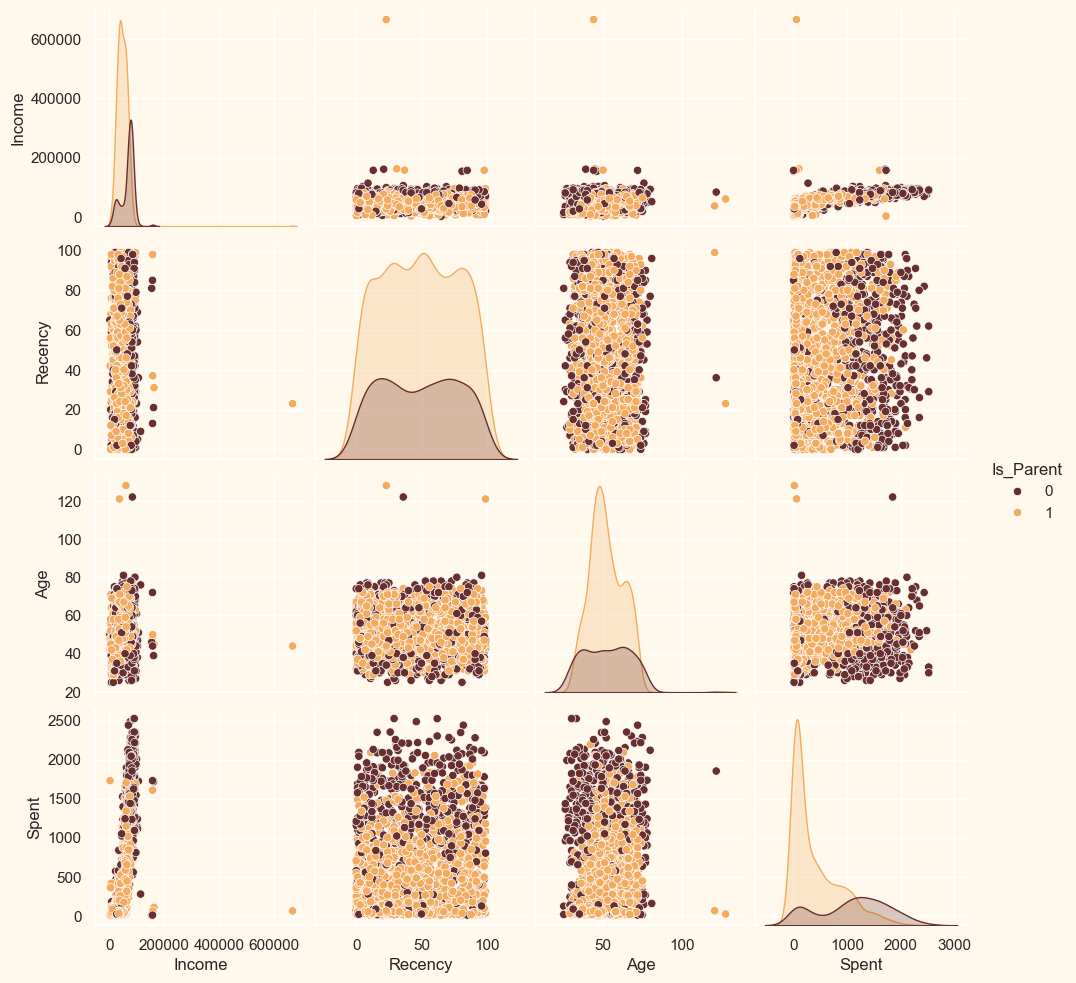

In [15]:
# To plot some selected features 
#Setting up colors prefrences
from matplotlib import colors
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "Income", "Recency", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()

In [16]:
#Dropping the outliers by setting a cap on Age and income. 
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


In [17]:
# data preprocessing
cat_features=[feature for feature in data.columns if data[feature].dtype==object]
numerical_features=[feature for feature in data.columns if data[feature].dtype!=object]


In [18]:
from sklearn.model_selection import train_test_split
X=data.drop(['Response'],axis=1)
y=data['Response']

In [19]:
# applying column transformer
cat_feature=X.select_dtypes(include='object').columns
print("Toatal number of categorical data",cat_features)
num_feature=X.select_dtypes(exclude='object').columns

from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer

numeric_tranformer=StandardScaler()
oh_transformer=OneHotEncoder(drop='first')

preprocessor=ColumnTransformer(
    [
        ("OneHotEncoder",oh_transformer,cat_feature),
        ('StandardScaler',numeric_tranformer,num_feature)
        
    ]
)

Toatal number of categorical data ['Education', 'Living_With']


In [20]:
X['Education'].value_counts()

Education
Graduate         1115
Postgraduate      845
Undergraduate     252
Name: count, dtype: int64

In [21]:
preprocessor

ColumnTransformer(transformers=[('OneHotEncoder', OneHotEncoder(drop='first'),
                                 Index(['Education', 'Living_With'], dtype='object')),
                                ('StandardScaler', StandardScaler(),
                                 Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'Wines', 'Fruits', 'Meat',
       'Fish', 'Sweets', 'Gold', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Age', 'Spent', 'Children', 'Family_Size',
       'Is_Parent'],
      dtype='object'))])

In [22]:
X=preprocessor.fit_transform(X)

In [36]:
pca=PCA(n_components=2)

In [37]:
X=pca.fit_transform(X)

In [57]:
PCA_ds = pd.DataFrame(pca.fit_transform(X), columns=(["col1","col2"]))

In [58]:
PCA_ds

,col1,col2
0,4.628715,-0.406211
1,-2.922083,0.300744
2,2.428480,-0.874145
3,-2.666603,-1.506882
4,-0.694287,0.207433
...,...,...
2207,2.130843,2.196786
2208,-2.450466,4.229241
2209,2.761766,-1.251635
2210,1.391522,1.774655


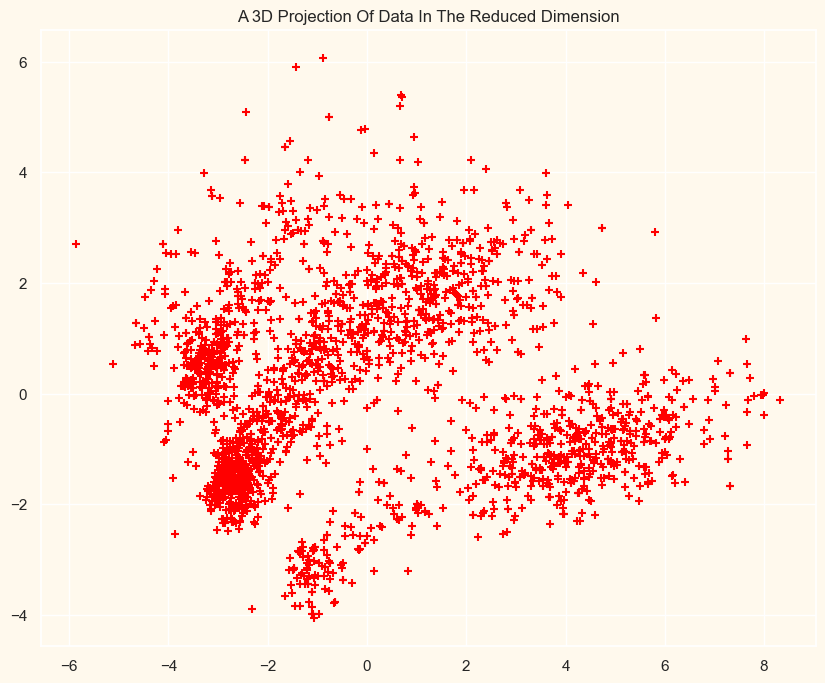

In [61]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
# z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.scatter(x,y, c="red", marker="+" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

In [62]:
# Kmeans
# Elbow method
wcss=[]
for k in range(1,11):
    kmeans=KMeans(n_clusters=k,init="k-means++")
    kmeans.fit(PCA_ds)
    wcss.append(kmeans.inertia_)

In [63]:
wcss

[25575.965868406252,
 10861.909235479026,
 6467.3767434652145,
 4603.535573161558,
 3852.1384070542363,
 3412.744306308593,
 3105.573659111057,
 2463.968366142405,
 1979.1395312753193,
 1734.593520281232]

Text(0, 0.5, 'WCSS')

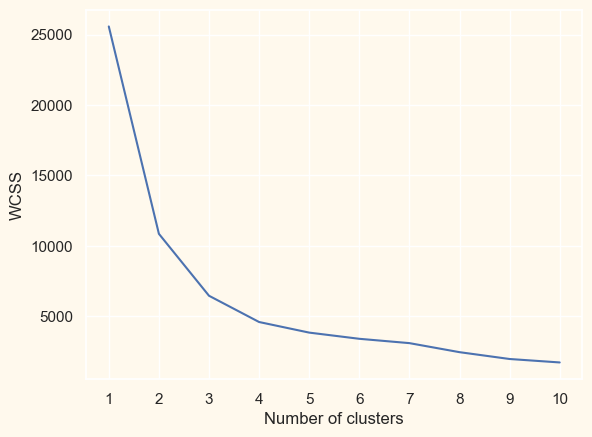

In [64]:
plt.plot(range(1,11),wcss)
plt.xticks(range(1,11))
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")

In [65]:
kmeans=KMeans(n_clusters=2,init="k-means++")

In [66]:
pred=kmeans.fit_predict(PCA_ds)

In [67]:
pred

array([1, 0, 1, ..., 1, 1, 0])

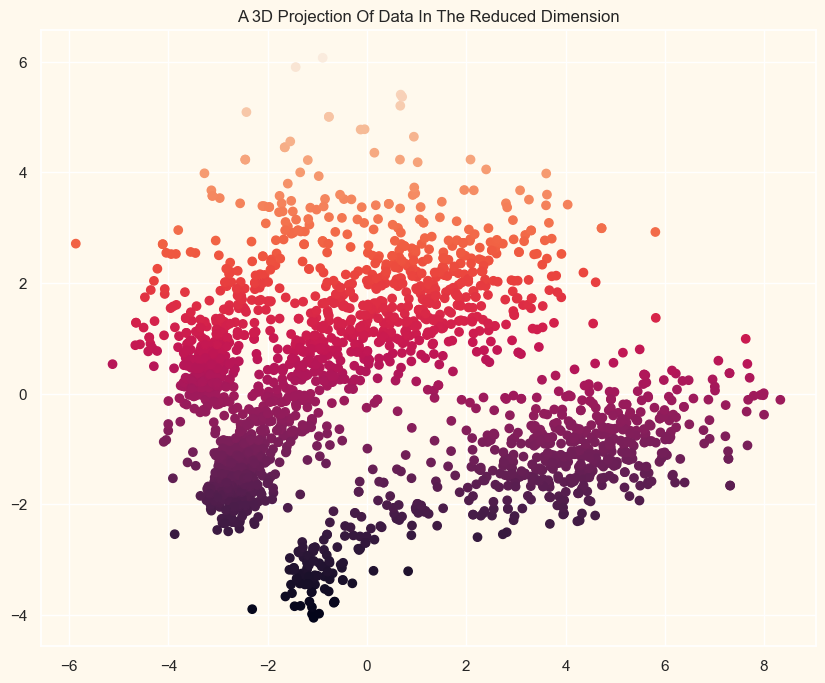

In [79]:

#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.scatter(x,y ,c=y, marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

In [70]:
# DBscan

In [71]:
dbscan=DBSCAN(eps=0.3)

In [72]:
dbscan.fit(PCA_ds)

DBSCAN(eps=0.3)

In [73]:
dbscan.labels_

array([0, 1, 0, ..., 0, 1, 1], dtype=int64)

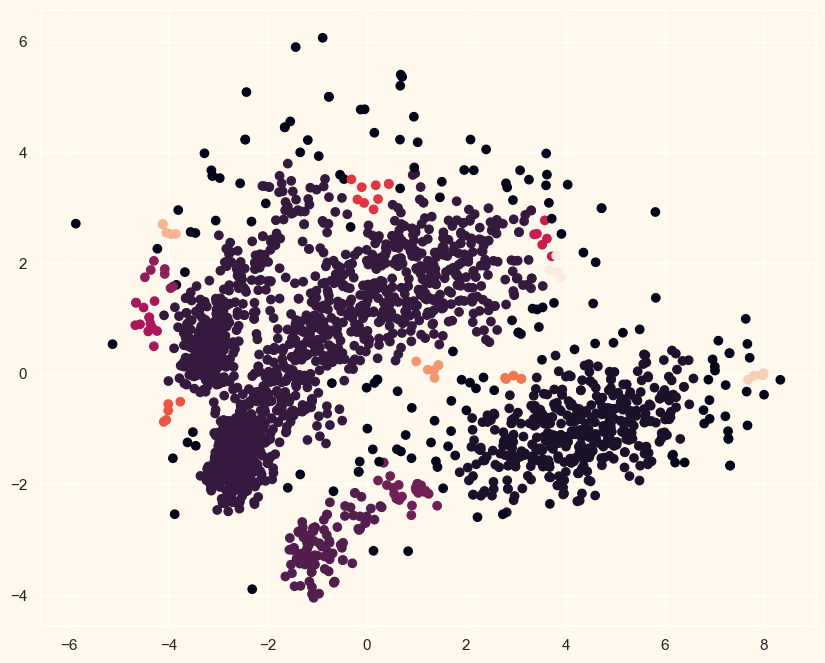

In [78]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.scatter(x,y ,c=dbscan.labels_, marker="o" )
# plt.scatter(x,y,c=dbscan.labels_)